In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (95).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (26).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (29).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (30).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (65).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (15).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (7).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (10).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (70).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (88).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (12).jpg
/kaggle/input/padangfood/dataset_padang_food/gulai_tambusu/gulai_tambusu (66).jpg
/kaggle/input/pad

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
import random
import cv2
import json
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-06-16 04:53:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-16 04:53:59 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Load data
dataset = "../input/padangfood/dataset_padang_food"
walk_through_dir(dataset)

There are 9 directories and 0 images in '../input/padangfood/dataset_padang_food'.
There are 0 directories and 103 images in '../input/padangfood/dataset_padang_food/gulai_tambusu'.
There are 0 directories and 109 images in '../input/padangfood/dataset_padang_food/dendeng_batokok'.
There are 0 directories and 113 images in '../input/padangfood/dataset_padang_food/ayam_pop'.
There are 0 directories and 104 images in '../input/padangfood/dataset_padang_food/daging_rendang'.
There are 0 directories and 111 images in '../input/padangfood/dataset_padang_food/telur_balado'.
There are 0 directories and 116 images in '../input/padangfood/dataset_padang_food/telur_dadar'.
There are 0 directories and 107 images in '../input/padangfood/dataset_padang_food/ayam_goreng'.
There are 0 directories and 111 images in '../input/padangfood/dataset_padang_food/gulai_ikan'.
There are 0 directories and 119 images in '../input/padangfood/dataset_padang_food/gulai_tunjang'.


In [5]:
# Adding data to the Dataframe
image_dir = Path(dataset)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df

Filepath          Label
0    ../input/padangfood/dataset_padang_food/gulai_...  gulai_tambusu
1    ../input/padangfood/dataset_padang_food/gulai_...  gulai_tambusu
2    ../input/padangfood/dataset_padang_food/gulai_...  gulai_tambusu
3    ../input/padangfood/dataset_padang_food/ayam_p...       ayam_pop
4    ../input/padangfood/dataset_padang_food/ayam_p...       ayam_pop
..                                                 ...            ...
989  ../input/padangfood/dataset_padang_food/gulai_...  gulai_tunjang
990  ../input/padangfood/dataset_padang_food/gulai_...  gulai_tunjang
991  ../input/padangfood/dataset_padang_food/gulai_...  gulai_tunjang
992  ../input/padangfood/dataset_padang_food/ayam_g...    ayam_goreng
993  ../input/padangfood/dataset_padang_food/ayam_g...    ayam_goreng

[994 rows x 2 columns]

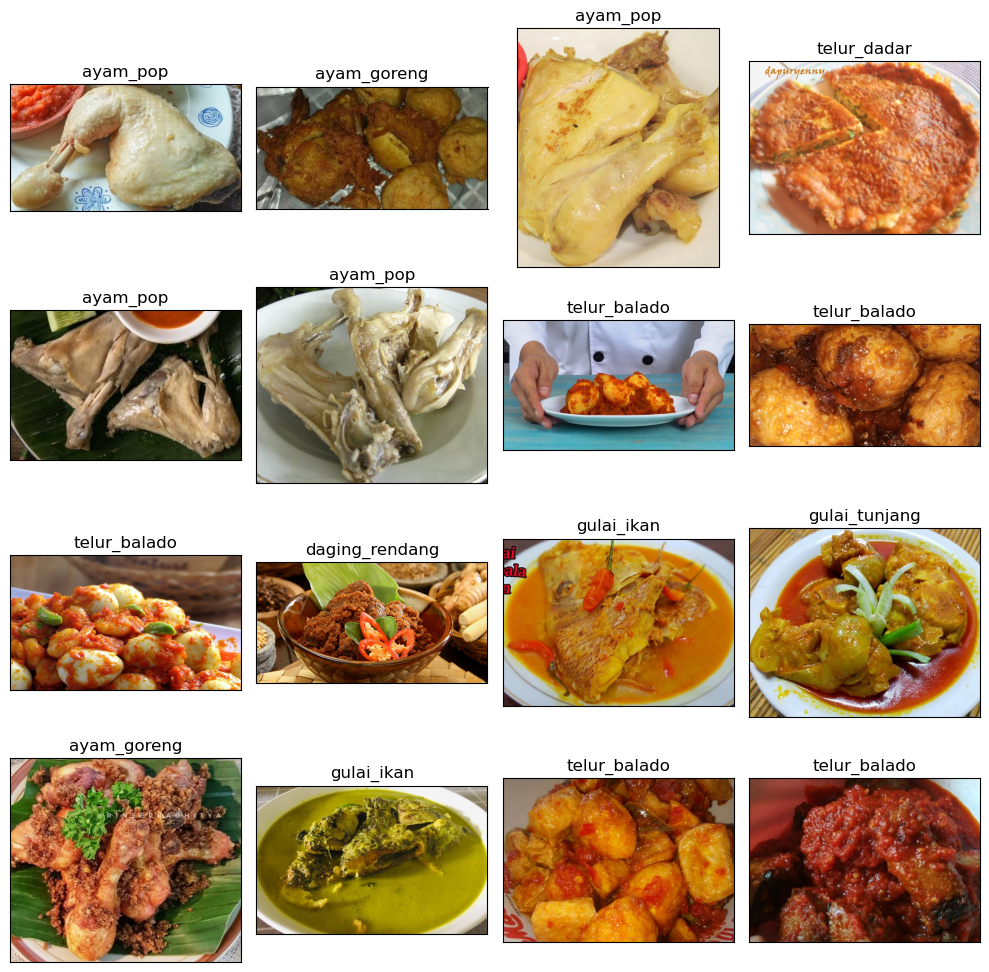

In [6]:
# Image visualization from the dataset
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:
# This function computes the Error Level Analysis (ELA) of an image
def compute_ela_cv(path, quality):
    
    # Create temporary filename
    temp_filename = 'temp_filename.jpeg'
    
    # define the number of scales to use
    scales = 15
    
    # read original image
    orginal_img = cv2.imread(path)
    
    # convert the original image to RGB
    orginal_img = cv2.cvtColor(orginal_img, cv2.COLOR_BGR2RGB)
    
    # Save the original image with the specified JPEG quality
    cv2.imwrite(temp_filename, orginal_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    
    # read compressed image
    compressed_img = cv2.imread(temp_filename)
    
    # Multiply the absolute difference between the original and compressed photos by the scaling factor.
    diff = scales * cv2.absdiff(orginal_img, compressed_img)
    
    #return diff
    return diff

# this function converts an image to its ELA representation
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_filename.jpeg'
    ela_filename = 'temp_ela.png'
    
    # Open the image and convert it to RGB format
    image = Image.open(path).convert('RGB')
    
    # Save the image with the specified JPEG quality
    image.save(temp_filename, 'JPEG', quality = quality)
    
    # Open the temporary image and compute the difference between the original and compressed images
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    
    # determine the greatest difference between the pixels in the ELA image.
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    
# returns a random file with the provided extension from a directory.
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')     
    items = list(items)    
    random_img = random.choice(items)
    return random_img.as_posix()

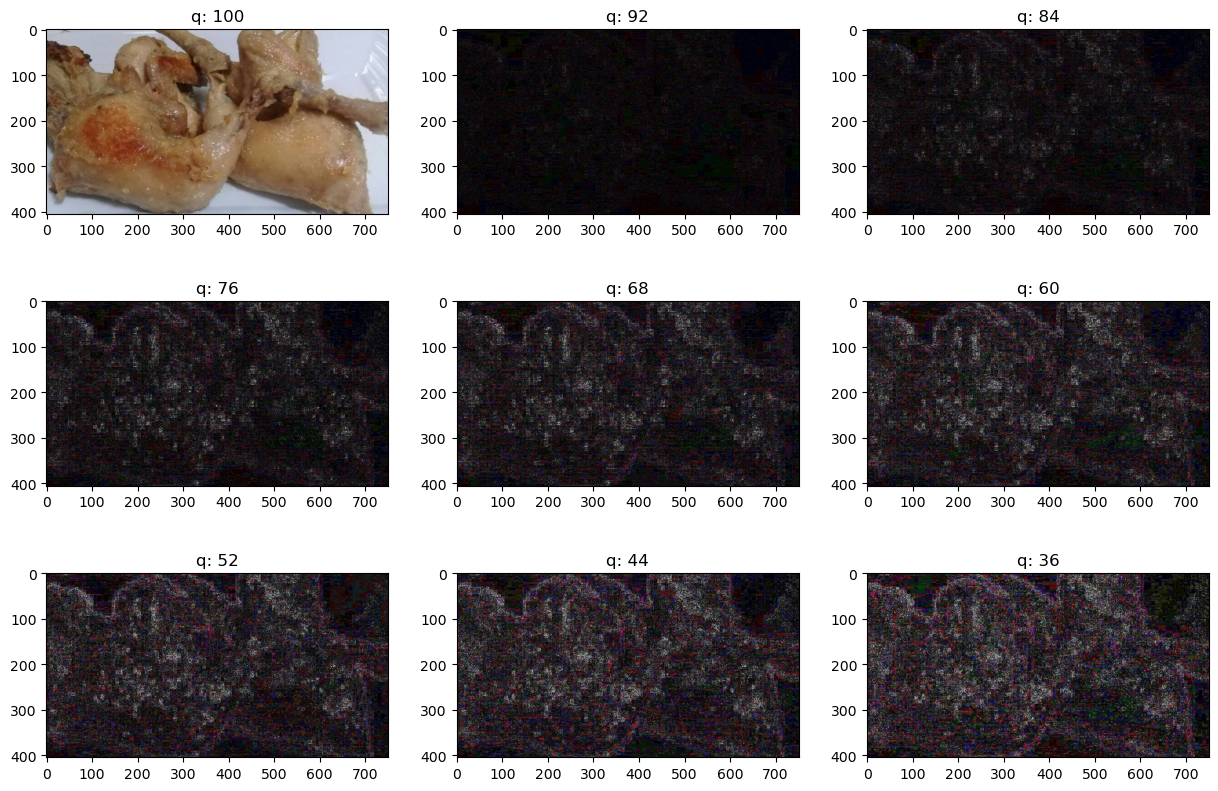

In [8]:
# Get a random image from the dataset
random_img = random_sample('../input/padangfood/dataset_padang_food/ayam_pop')
orginal_img = cv2.imread(random_img)
orginal_img = cv2.cvtColor(orginal_img, cv2.COLOR_BGR2RGB) / 255.0
# Set initial quality value and number of rows and columns for the plot
init = 100
columns = 3
rows = 3
# Create a plot to display the images
fig=plt.figure(figsize=(15, 10))
for i in range(1, columns * rows + 1):
    # Calculate the quality value for the current image
    quality = init - (i - 1) * 8
    # Apply the quality degradation effect to the image
    degraded_img = compute_ela_cv(path = random_img,quality = quality)
    if i == 1:
        degraded_img = orginal_img.copy()
    # Add the image to the plot
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(degraded_img)
plt.show()

In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, 
                                     test_size=0.2, 
                                     shuffle=True, 
                                     random_state=42)
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [10]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 636 validated image filenames belonging to 9 classes.


In [11]:
#validation
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 159 validated image filenames belonging to 9 classes.


In [12]:
#testing
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 199 validated image filenames belonging to 9 classes.


In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# Create checkpoint callback
checkpoint_path = "foods_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

12683000/12683000 [==============================] - 0s 0us/step


In [14]:
# Define the input layer of the neural network model
input_layer_nn = pretrained_model.input

# resize and rescale the input images
rescaled_images_nn = resize_and_rescale(input_layer_nn)

# Add dense layers with ReLU activation and dropout regularization to the neural network model
dense_layer_1_nn = Dense(256, activation='relu')(pretrained_model.output)
dropout_layer_1_nn = Dropout(0.2)(dense_layer_1_nn)
dense_layer_2_nn = Dense(256, activation='relu')(dropout_layer_1_nn)
dropout_layer_2_nn = Dropout(0.2)(dense_layer_2_nn)

# Define the output layer of the neural network model with softmax activation
output_layer_nn = Dense(9, activation='softmax')(dropout_layer_2_nn)

# Define the neural network model with the input and output layers
model_nn = Model(inputs=input_layer_nn, outputs=output_layer_nn)

# Compile the neural network model with Adam optimizer, categorical crossentropy loss and accuracy metric
model_nn.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the nn model with the training and validation data, using early stopping, tensorboard and checkpoint callbacks
history_nn = model_nn.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "food_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/food_classification/20230616-045407
Epoch 1/100
20/20 [==============================] - 16s 609ms/step - loss: 2.5278 - accuracy: 0.1289 - val_loss: 2.2130 - val_accuracy: 0.1447
Epoch 2/100
20/20 [==============================] - 10s 516ms/step - loss: 2.4106 - accuracy: 0.1352 - val_loss: 2.1489 - val_accuracy: 0.1572
Epoch 3/100
20/20 [==============================] - 10s 516ms/step - loss: 2.3111 - accuracy: 0.1698 - val_loss: 2.0976 - val_accuracy: 0.1824
Epoch 4/100
20/20 [==============================] - 11s 545ms/step - loss: 2.2239 - accuracy: 0.1792 - val_loss: 2.0512 - val_accuracy: 0.1950
Epoch 5/100
20/20 [==============================] - 10s 502ms/step - loss: 2.1432 - accuracy: 0.1918 - val_loss: 2.0080 - val_accuracy: 0.2327
Epoch 6/100
20/20 [==============================] - 11s 532ms/step - loss: 2.1226 - accuracy: 0.2170 - val_loss: 1.9690 - val_accuracy: 0.2704
Epoch 7/100
20/20 [==============================] - 

    Test Loss: 0.40031
Test Accuracy: 87.44%


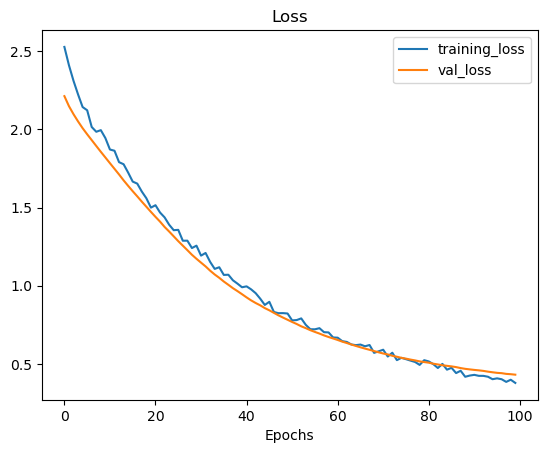

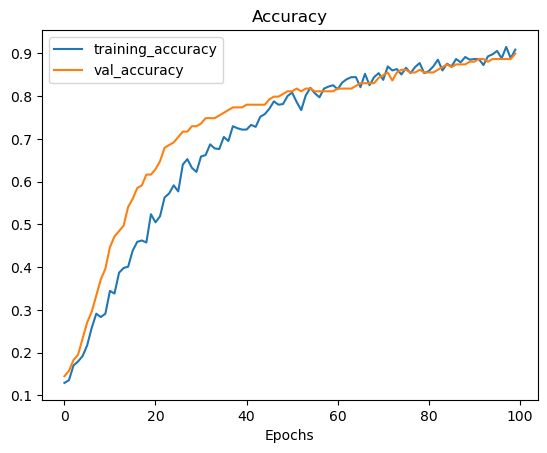

In [15]:
# model evaluation
results = model_nn.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

plot_loss_curves(history_nn)

In [16]:
# Predict the label of the test_images
pred = model_nn.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

7/7 [==============================] - 3s 321ms/step


['gulai_tunjang',
 'telur_balado',
 'telur_dadar',
 'telur_dadar',
 'gulai_tunjang',
 'daging_rendang',
 'gulai_ikan',
 'ayam_goreng',
 'dendeng_batokok',
 'telur_dadar',
 'gulai_ikan',
 'dendeng_batokok',
 'gulai_ikan',
 'telur_dadar',
 'gulai_tambusu',
 'daging_rendang',
 'gulai_tunjang',
 'dendeng_batokok',
 'dendeng_batokok',
 'ayam_pop',
 'ayam_goreng',
 'telur_balado',
 'ayam_goreng',
 'gulai_tambusu',
 'daging_rendang',
 'daging_rendang',
 'gulai_tambusu',
 'ayam_pop',
 'gulai_ikan',
 'dendeng_batokok',
 'dendeng_batokok',
 'ayam_goreng',
 'telur_dadar',
 'gulai_tunjang',
 'ayam_pop',
 'gulai_ikan',
 'ayam_pop',
 'gulai_ikan',
 'gulai_tunjang',
 'ayam_pop',
 'gulai_tambusu',
 'ayam_pop',
 'daging_rendang',
 'telur_dadar',
 'daging_rendang',
 'ayam_goreng',
 'gulai_tambusu',
 'gulai_tambusu',
 'gulai_tambusu',
 'telur_balado',
 'ayam_goreng',
 'telur_balado',
 'gulai_ikan',
 'telur_balado',
 'telur_dadar',
 'ayam_pop',
 'ayam_pop',
 'telur_dadar',
 'dendeng_batokok',
 'daging_ren

In [17]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
def output(location):
    img = load_img(location,target_size=(224,224,3))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,[0])
    answer = model_nn.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [18]:
img = output('/kaggle/input/padangfood/dataset_padang_food/ayam_goreng/ayam_goreng (103).jpg')
img

1/1 [==============================] - 1s 843ms/step


'telur_dadar'

In [19]:
# predict the label of the test_images
pred = model_nn.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 2s 319ms/step
The first 5 predictions: ['gulai_tunjang', 'telur_balado', 'telur_dadar', 'telur_dadar', 'gulai_tunjang']


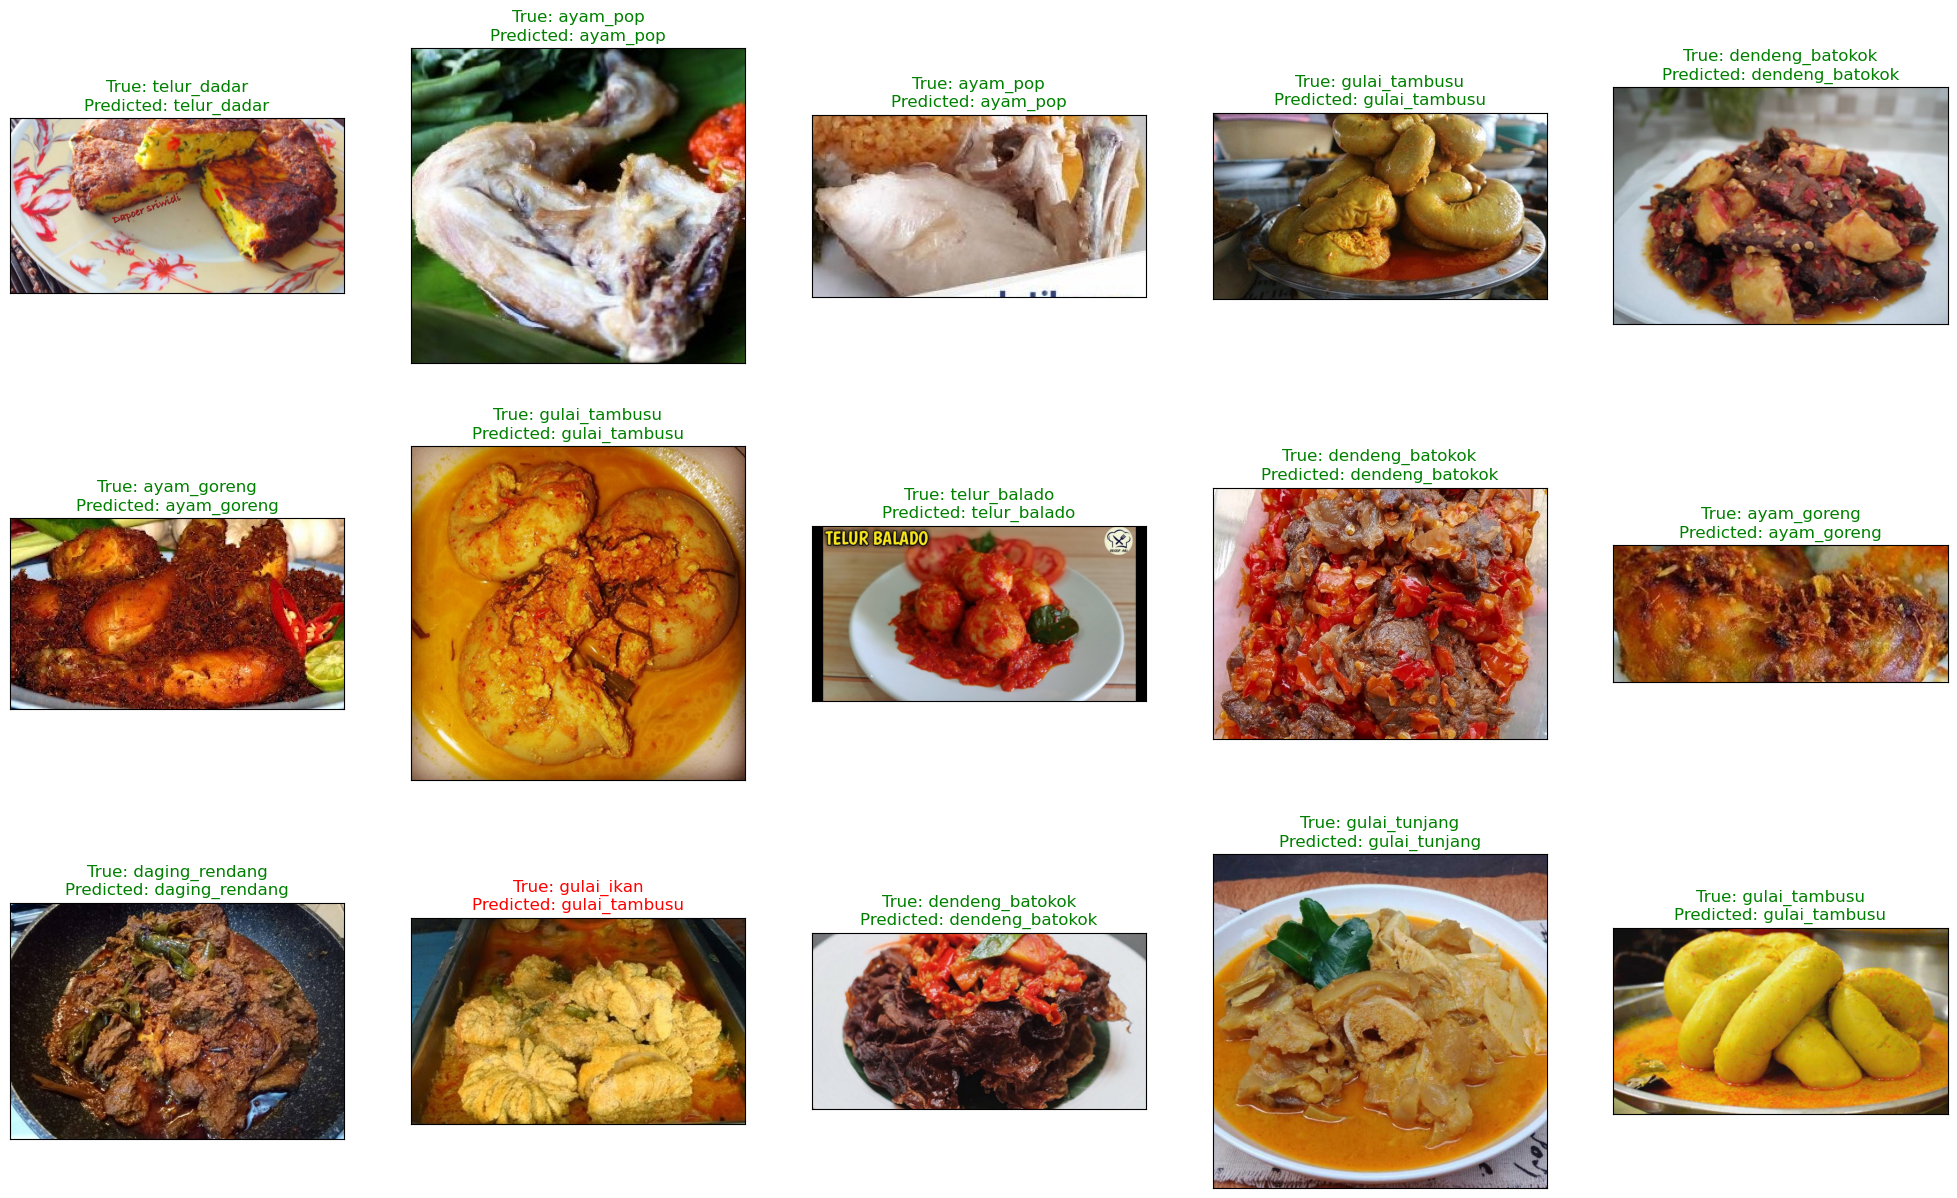

                 precision    recall  f1-score   support

    ayam_goreng       0.94      0.89      0.92        19
       ayam_pop       0.93      0.96      0.95        27
 daging_rendang       0.89      0.89      0.89        19
dendeng_batokok       0.94      0.94      0.94        18
     gulai_ikan       0.81      0.71      0.76        24
  gulai_tambusu       0.82      0.86      0.84        21
  gulai_tunjang       0.78      0.78      0.78        23
   telur_balado       0.92      0.88      0.90        25
    telur_dadar       0.85      0.96      0.90        23

       accuracy                           0.87       199
      macro avg       0.88      0.88      0.87       199
   weighted avg       0.87      0.87      0.87       199



<Figure size 640x480 with 0 Axes>

In [20]:
# display some random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, 
                         ncols=5, 
                         figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [21]:
# shows classification report
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
ayam_goreng       0.944444  0.894737  0.918919   19.000000
ayam_pop          0.928571  0.962963  0.945455   27.000000
daging_rendang    0.894737  0.894737  0.894737   19.000000
dendeng_batokok   0.944444  0.944444  0.944444   18.000000
gulai_ikan        0.809524  0.708333  0.755556   24.000000
gulai_tambusu     0.818182  0.857143  0.837209   21.000000
gulai_tunjang     0.782609  0.782609  0.782609   23.000000
telur_balado      0.916667  0.880000  0.897959   25.000000
telur_dadar       0.846154  0.956522  0.897959   23.000000
accuracy          0.874372  0.874372  0.874372    0.874372
macro avg         0.876148  0.875721  0.874983  199.000000
weighted avg      0.874394  0.874372  0.873384  199.000000

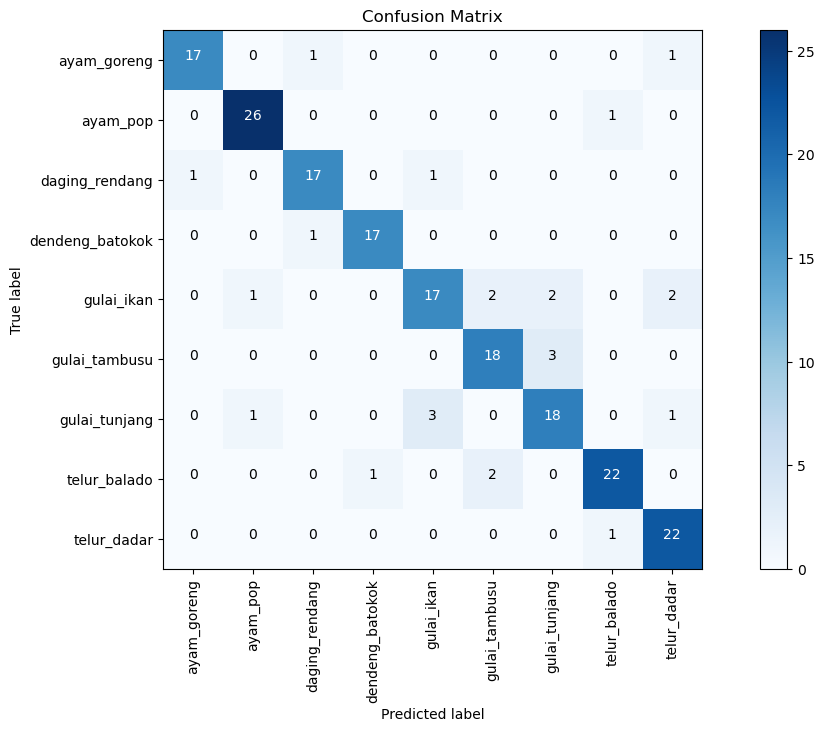

In [22]:
def make_confusion_matrix(y_true, 
                          y_pred, 
                          classes=None, 
                          figsize=(15, 7), 
                          text_size=10, 
                          norm=False, 
                          savefig=False): 
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]
    
    # plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    
    # colors will represent how correct a class is, darker means better
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
        
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
           
        # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels,
           
        # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    # added rotate xticks for readability & increase font size
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.
    
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

# show the graphic
make_confusion_matrix(y_test, pred, list(labels.values()))

In [23]:
#Save the trained model as a Keras HDF5 file. 

saved_model_path = "./my_model.h5"
model_nn.save(saved_model_path)

In [24]:
# convert model to tflite model
model = tf.keras.models.load_model('my_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

13149196